In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Available Jobs

In [2]:
import os, pathlib, time
import pandas as pd
from IPython.display import display, HTML
import json
import numpy as np

CSS = """
.output {
    flex-direction: row;
}
"""
start_with_prefix='2676'

HTML('<style>{}</style>'.format(CSS))

basedir = pathlib.Path(os.path.abspath('/data/Jiang_Lab/Data/MT-TS-Net/code/'))
checkpoint_dir = pathlib.Path(os.path.abspath('/data/Jiang_Lab/Data/MT-TS-Net-checkpoint/'))
output_dir = pathlib.Path(os.path.abspath('/data/Jiang_Lab/Data/MT-TS-Net-output/'))
logdir = pathlib.Path(os.path.abspath('/data/Jiang_Lab/Data/MT-TS-Net/code/'))

jobids = sorted([d for d in os.listdir(checkpoint_dir) if os.path.isdir(checkpoint_dir / d) and d.startswith(start_with_prefix)])

import re
import pandas as pd
metadata={}
opts = []
metadata_df = pd.DataFrame()

for jobid in jobids:
    metadata['jobids'] = jobid
    if os.path.exists('../slurm-'+ jobid +'.out'):
        logfile = '../slurm-'+ jobid +'.out'
    #else:
    #    logfile = './jobs/train'+ jobid +'.log'
        
    with open(logfile) as fin:
        lines = " ".join(line.strip() for line in fin) 
        metadata['batch_size'] = re.findall(r"batch_size=([0-9]+)", lines)[0]
        metadata['num_patch'] = re.findall(r"num_patch=([0-9]+)", lines)[0]
        metadata['patch_size'] = re.findall(r"patch_size=([0-9]+)", lines)[0]
        if len(re.findall(r"recon_size=([0-9]+)", lines))>0:
            metadata['recon_size'] = re.findall(r"recon_size=([0-9]+)", lines)[0]
        else:
            metadata['recon_size'] = 'NA'  
        if len(re.findall(r"kl_coeff=([0-9]\.[0-9]+)", lines))>0:
            metadata['kl_coeff'] = re.findall(r"kl_coeff=([0-9]\.[0-9]+)", lines)[0]
        elif len(re.findall(r"kl_coeff=([0-9]+e-[0-9]+)", lines))>0:
            metadata['kl_coeff'] = re.findall(r"kl_coeff=([0-9]+e-[0-9]+)", lines)[0]
        else:
            metadata['kl_coeff']='NA'
        metadata['dropout_rate'] = re.findall(r"dropout_rate=(0\.[0-9]+)", lines)[0]
        metadata['multitask'] = re.findall(r"multitask=([A-Za-z]+),", lines)[0]
        if len(re.findall(r"bayesian_train=True", lines))>0:
            metadata['bayesian_train'] = 'True'
        else:
            metadata['bayesian_train'] = 'False'
        
        dcsv = re.findall(r"dataset_csv=(\'.*data.csv\')", lines)
        if len(dcsv)>0:
            metadata['dataset_csv'] = dcsv[0].split('/')[-1]
        else:
            metadata['dataset_csv'] = 'NA'
        if len(re.findall(r"learning\_rate=(0\.[0-9]+)", lines))>0:
            metadata['lr'] = re.findall(r"learning\_rate=(0\.[0-9]+)", lines)[0]
        elif len(re.findall(r"learning\_rate=([0-9]+e-[0-9]+)", lines))>0:
            metadata['lr'] = re.findall(r"learning\_rate=([0-9]+e-[0-9]+)", lines)[0]
        else:
            metadata['lr'] = 'NA'
    if os.path.exists('../model_'+ jobid +'.json'):
        with open('../model_'+ jobid +'.json') as f:
            json_doc = json.load(f)
        metadata['modelarch'] = json_doc['modelarch']
        metadata['MIL_pool'] = json_doc['MIL_pool']
        if 'duration_quantiles' in json_doc.keys():
            metadata['duration_quantiles'] = json_doc['duration_quantiles']
        else: 
            metadata['duration_quantiles'] = 'NA'
    metadata_df = metadata_df.append(metadata, ignore_index=True)
metadata_df = metadata_df[['jobids', 'num_patch', 'batch_size', 'dataset_csv', 'modelarch', 'patch_size', 'multitask', 'lr', 'MIL_pool', 'duration_quantiles', 'dropout_rate', 'recon_size', 'kl_coeff']]
display(metadata_df)

,jobids,num_patch,batch_size,dataset_csv,modelarch,patch_size,multitask,lr,MIL_pool,duration_quantiles,dropout_rate,recon_size,kl_coeff
0,26763022,32,12,casewise_linked_data.csv',resnet18,224,True,5e-05,gated_attention,"[0.25, 0.5, 0.75]",0.5,64,0.0


## Select job ids

In [3]:
for index, metadata in metadata_df.iterrows():
    opts.append(
        metadata['jobids']
        + '_modelarch_' + metadata['modelarch']
        + '_recon_size_' + metadata['recon_size']
        + '_batch_size_' + metadata['batch_size']
        + '_num_patch_' + metadata['num_patch']
        + '_patch_size_' + metadata['patch_size']  
        + '_lr_' + metadata['lr']
        + '_dropout_' + metadata['dropout_rate']
        + '_kl_coeff_' + metadata['kl_coeff']
    )

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Layout

s_jobids = widgets.SelectMultiple(
    options=opts,
    value=[opts[0]],
    description='jobs:',
    disabled=False,
    rows=len(opts),
    layout=Layout(display="flex", flex_flow='column')
)
display(s_jobids)

SelectMultiple(description='jobs:', index=(0,), layout=Layout(display='flex', flex_flow='column'), options=('2…

###### Visualize loss and concordance indices for selected jobs

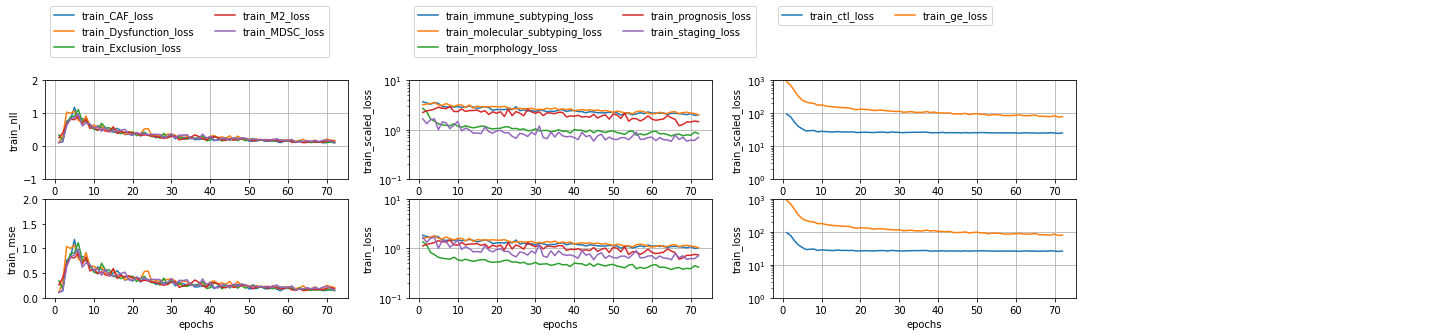

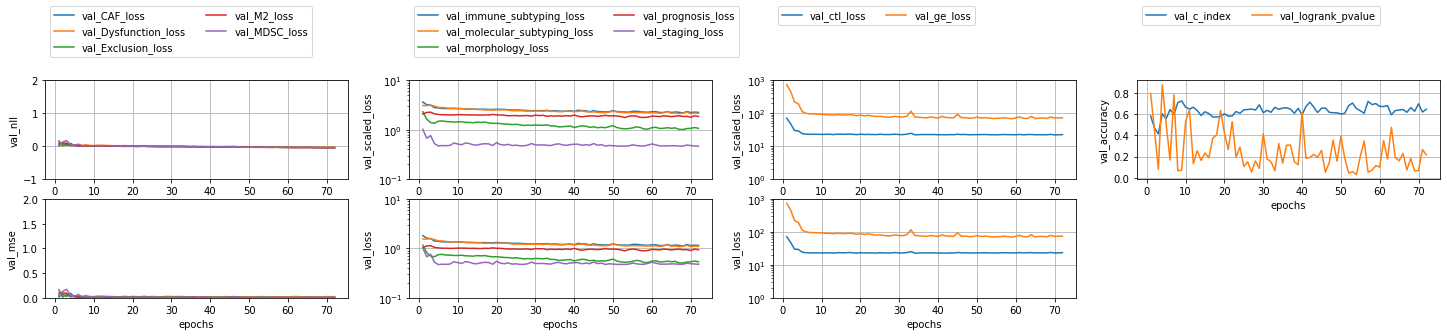

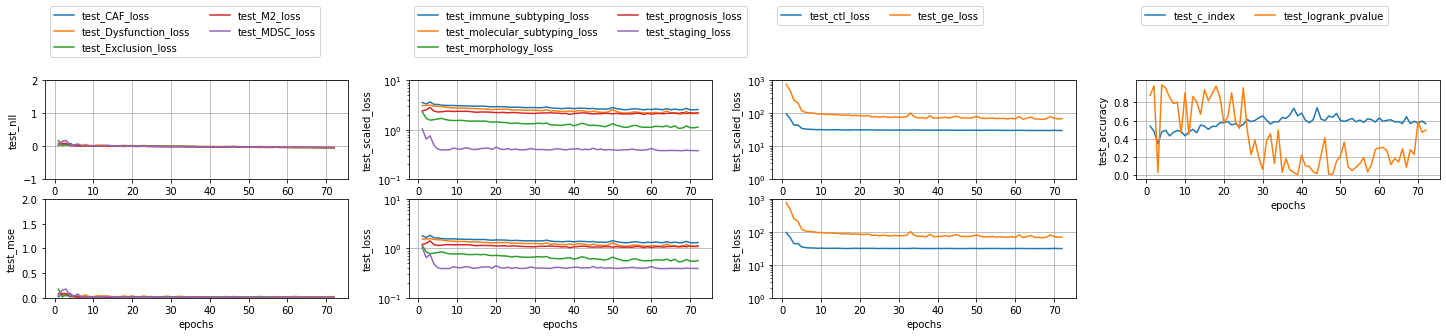

In [4]:
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.pyplot as plt 

for s_jobid in s_jobids.value:
    s_jobid_splits = s_jobid.split('_')
    s_jobid = s_jobid_splits[0]
    s_model = s_jobid_splits[2]
    if s_model=='inception':
        offset=1
    else:
        offset=0
    s_recon_size = s_jobid_splits[5+offset]
    s_batch_size = s_jobid_splits[8+offset]
    s_num_patch = s_jobid_splits[11+offset]
    s_lr = s_jobid_splits[16+offset]
    s_dropout=s_jobid_splits[18+offset]
    s_kl = s_jobid_splits[21+offset]
    
    epmetrics = pd.read_csv(os.path.join(output_dir, 'epoch_metrics_'+ s_jobid + '.csv'))
    eplist = [x+1 for x in range(len(epmetrics))]
    
    for split in ['train', 'val', 'test']:
        #fig = plt.figure()
        fig, axs = plt.subplots(2, 4, figsize=(25,4))
        axs[-1,-1].axis('off')
        if split=='train':
            axs[0,3].axis('off')
        axs[0,0].set_ylabel(split+'_nll')
        axs[0,0].set_ylim([-1,2])
        axs[0,0].set_xlabel('epochs')
        #axs[0,0].set_title(s_jobid + '_' + s_model + '_np' + s_num_patch + '_bs' + s_batch_size + '_lr' + s_lr + '_do' + s_dropout + '_rs' + s_recon_size +'_kl'+s_kl)
        axs[0,0].grid()
        axs[0,1].set_yscale('log')
        axs[0,1].set_ylabel(split+'_scaled_loss')
        axs[0,1].set_ylim([0.1,10])
        axs[0,1].set_xlabel('epochs')
        #axs[0,1].set_title(s_jobid + '_' + s_model + '_np' + s_num_patch + '_bs' + s_batch_size + '_lr' + s_lr + '_do' + s_dropout + '_rs' + s_recon_size +'_kl'+s_kl)
        axs[0,1].grid()
        axs[0,2].set_ylabel(split+'_scaled_loss')
        axs[0,2].set_ylim([1,1000])
        axs[0,2].set_xlabel('epochs')
        axs[0,2].grid()
        if split in ['val', 'test']:
            axs[0,3].set_ylabel(split+'_accuracy')
            axs[0,3].set_xlabel('epochs')
            axs[0,3].set_yticks(np.arange(0, 1, step=0.2))
            #axs[0,3].set_title(s_jobid + '_' + s_model + '_np' + s_num_patch + '_bs' + s_batch_size + '_lr' + s_lr + '_do' + s_dropout + '_rs' + s_recon_size+'_kl'+s_kl)        
            axs[0,3].grid()
        axs[1,0].set_ylabel(split+'_mse')
        axs[1,0].set_ylim([0,2])
        axs[1,0].grid()
        axs[1,0].set_xlabel('epochs')
        axs[1,1].set_yscale('log')
        axs[1,1].set_ylabel(split+'_loss')
        axs[1,1].set_ylim([0.1,10])
        axs[1,1].set_xlabel('epochs')
        axs[1,1].grid()
        axs[1,2].set_ylabel(split+'_loss')
        axs[1,2].set_ylim([1,1000])
        axs[1,2].set_xlabel('epochs')
        axs[1,2].grid()
        
        TIDE_list = {}
        TIDE_list[split]= [split+'_Dysfunction_loss', split+'_Exclusion_loss', split+'_MDSC_loss', split+'_CAF_loss', split+'_M2_loss']
        
        us_TIDE_list = {}
        us_TIDE_list[split]= [split+'_us_Dysfunction_loss', split+'_us_Exclusion_loss', split+'_us_MDSC_loss', split+'_us_CAF_loss', split+'_us_M2_loss' ]
        
        
        MISC_list_1 = {}
        MISC_list_1[split] = [split+'_immune_subtyping_loss', split+'_molecular_subtyping_loss', split+'_staging_loss', split+'_morphology_loss', split+'_prognosis_loss']
        
        us_MISC_list_1 = {}
        us_MISC_list_1[split] = [split+'_us_immune_subtyping_loss', split+'_us_molecular_subtyping_loss', split+'_us_staging_loss', split+'_us_morphology_loss', split+'_us_prognosis_loss']
        
        MISC_list_2 = {}
        MISC_list_2[split] = [split+'_ctl_loss', split+'_ge_loss', split+'_recon_loss', split+'_kl_loss']
        
        us_MISC_list_2 = {}
        us_MISC_list_2[split] = [split+'_us_ctl_loss', split+'_us_ge_loss', split+'_us_recon_loss', split+'_us_kl_loss']
        
        
        Prog_list = {}
        Prog_list[split] = [split+'_c_index', split+'_logrank_pvalue']
        
        for c in epmetrics.columns.values:
            if c.startswith(split):
                if c in TIDE_list[split]:
                    axs[0,0].plot(eplist, epmetrics[c].values, label=c)
                    axs[0,0].legend(ncol=2, bbox_to_anchor=(0, 1.8), loc='upper left')
                elif c in us_TIDE_list[split]:
                    axs[1,0].plot(eplist, epmetrics[c].values, label=c)
                    axs[1,0].grid()
                elif c in MISC_list_1[split]:
                    axs[0,1].plot(eplist, epmetrics[c].values, label=c)
                    axs[0,1].legend(ncol=2, bbox_to_anchor=(0, 1.8), loc='upper left')
                elif c in us_MISC_list_1[split]:
                    axs[1,1].plot(eplist, epmetrics[c].values, label=c)
                elif c in MISC_list_2[split]:
                    axs[0,2].plot(eplist, epmetrics[c].values, label=c)
                    axs[0,2].set_yscale('log')
                    axs[0,2].legend(ncol=2, bbox_to_anchor=(0, 1.8), loc='upper left')
                elif c in us_MISC_list_2[split]:
                    axs[1,2].plot(eplist, epmetrics[c].values, label=c)
                    axs[1,2].set_yscale('log')
                elif c in Prog_list[split]:
                    axs[0,3].plot(eplist, epmetrics[c].values, label=c)
                    axs[0,3].legend(ncol=2, bbox_to_anchor=(0, 1.8), loc='upper left')